In [8]:
#Import Modules
import math
import requests
import csv
import collections

import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as sm

from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
#Pull HTML from UN website and parse
r = requests.get("http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm")
soup = BeautifulSoup(r.content,'html.parser')

In [3]:
#Extract data at appropriate level in structure
url_data=[]
for i in soup('table')[6]('tr'):
    #The groups of interest have a length of 25, hence this filter to exclude items not needed
    if len(i) == 25:
        url_data.append(i)

In [23]:
#Manipulate HTML data into DataFrame
col_list = ['Country','Year','Total','Men','Women']
UN_data = pd.DataFrame(columns=col_list)

#Ugly way
for i,entry in enumerate(url_data):
    UN_data.loc[i] = [int(entry('td')[v].get_text()) 
                      if v > 1 else entry('td')[v].get_text() 
                      for v in [0,1,4,7,10]]

#Pretty way
#I'll do this later..I promise


#Set country as index and drop old column
UN_data = UN_data.set_index('Country')

,Country,Year,Total,Men,Women
0,Afghanistan,2004,8.0,11.0,5.0
1,Albania,2004,11.0,11.0,11.0
2,Algeria,2005,13.0,13.0,13.0
3,Andorra,2008,11.0,11.0,12.0
4,Anguilla,2008,11.0,11.0,11.0


Mean School Life Expectancy for Total is 12.45
Median School Life Expectancy for Total is 13.00
Normality Test P-Value for Total is 0.44

Mean School Life Expectancy for Men is 12.39
Median School Life Expectancy for Men is 12.00
Normality Test P-Value for Men is 0.42

Mean School Life Expectancy for Women is 12.51
Median School Life Expectancy for Women is 13.00
Normality Test P-Value for Women is 0.06

Null Hypothesis: School Life Expectancy is equivalent for Men and Women regardless of country
T-Test P-Value: 0.72
Null Hypothesis Accepted


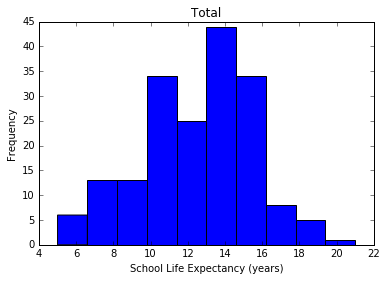

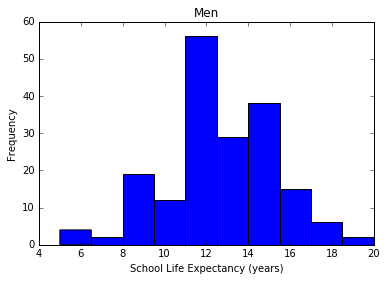

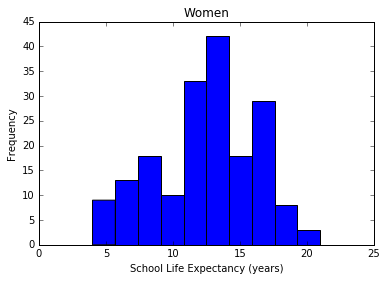

In [5]:
#Evaluate the data captured from the UN on school life
for col in col_list[2::]:
    
    s,p = sts.normaltest(UN_data[col])
    
    print('Mean School Life Expectancy for %s is %0.2f' % (col,UN_data[col].mean()))
    print('Median School Life Expectancy for %s is %0.2f' % (col,UN_data[col].median()))
    print('Normality Test P-Value for %s is %0.2f\n' % (col,p))
    
    plt.figure()
    plt.hist(UN_data[col])
    plt.title(col)
    plt.xlabel('School Life Expectancy (years)')
    plt.ylabel('Frequency')

#T-Test of Null Hypothesis
print('Null Hypothesis: School Life Expectancy is equivalent for Men and Women regardless of country')

s,p = sts.ttest_ind(UN_data['Men'],UN_data['Women'])
print('T-Test P-Value: %0.2f' % p)

if p > .05:
    print('Null Hypothesis Accepted')
else:
    print('Null Hypothesis REEEEjected!')


In [31]:
#Pull World Bank data into a DataFrame
fileName='API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv'
moneyData = pd.read_csv(fileName, header=2, usecols=['Country Name','1999','2000',
                                                     '2001','2002','2003','2004',
                                                     '2005','2006','2007','2008',
                                                     '2009','2010'])

#Relabel the DataFrame index & drop Country Name column
moneyData = moneyData.set_index('Country Name')

#Make index name SQLite friendly
moneyData.index.names= ['CountryName']

#Make column names SQLite friendly  
moneyData.columns = ['_'+str(yr) for yr in range(1999,2011)]

#Create database
con = sql.connect('WorldBankData.db')
cur = con.cursor()

#Create function to deal with SQLite weirdness about Unicode & text_factory
con.text_factory = lambda x: unicode(x,'utf-8','ignore')

#Push moneyData DataFrame into the database
cur.execute('DROP TABLE IF EXISTS gdp;')
moneyData.to_sql('gdp',con,flavor='sqlite')

#Push UN_data DataFrame into the database
cur.execute('DROP TABLE IF EXISTS education;')
UN_data.to_sql('education',con,flavor='sqlite')

In [7]:
#Generate selection for join
slct=''
for yr in range(1999,2011):
    slct=slct+',gdp._'+str(yr)

#Query database and insert into DataFrame
joinData=pd.read_sql('SELECT education.Country,education.Year,education.Total'+slct+
                     ' FROM education INNER JOIN gdp ON education.Country = gdp.CountryName',con)

In [8]:
#Match Education Year & GDP Year and pull GDP for that year
joinData['gdp'] = [joinData.loc[idx]['_'+str(joinData.loc[idx][1])] for idx in joinData.index]

#Generate list to drop....
slct=[]
for yr in range(1999,2011):
    slct.append('_'+str(yr))
#...and drop them
joinData=joinData.drop(slct,1)

In [22]:
#Perform log transform and store in new column
joinData['gdp_log']=[math.log(x) for x in joinData['gdp']]
joinData['Total_log']=[math.log(x) for x in joinData['Total']]
joinData=joinData.dropna()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     34.13
Date:                Thu, 28 Jul 2016   Prob (F-statistic):           3.26e-08
Time:                        12:43:38   Log-Likelihood:                -327.45
No. Observations:                 147   AIC:                             658.9
Df Residuals:                     145   BIC:                             664.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         13.9179      1.706      8.157      0.0

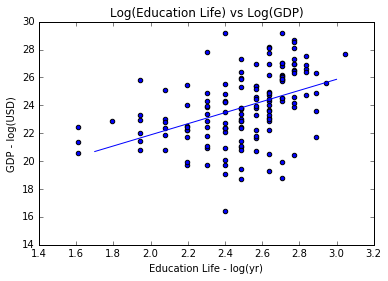

In [31]:
#Linear Regression
x=[x for x in joinData['Total_log']]
y=[y for y in joinData['gdp_log']]
x=sm.add_constant(x)
model=sm.OLS(y,x)
results=model.fit()

#Create linear regression data to plot
mX = [1.6 + 0.1*x for x in range(1,15)]
mY=[float(results.params[0]) + float(results.params[1])*x for x in mX]

#Plot data
plt.scatter(joinData['Total_log'],joinData['gdp_log'])
plt.plot(mX,mY)
plt.title('Log(Education Life) vs Log(GDP)')
plt.xlabel('Total Education Life - log(yr)')
plt.ylabel('GDP - log(USD)')

print(results.summary())

In [32]:
#A correlation between GDP and education life does not exist.  
#R-squared is only 19% and the model terms are not significant (p < .05).  
#There are a number of explanations for the lack of correlation.  
#First, education life and gdp was collected in different years which causes 
#time to be a confounding variable.  GDP and presumably education life are not 
#constant and can flucuate up or down.  Those variations could be masking the 
#real relationship between GDP and education life. Second, additional variables 
#may need to be considered to improve the model such as number of students enrolled, 
#level of education provided, number of institutions, etc.  Third, a major assumption
#made by using GDP is that a higher GDP means more money is spent on education.  
#Taxes for education can and have been rejected within the US, so GDP could rise 
#while education spending remains flat.  Therefore, we cannot assume education 
#spending tracks with GDP without further investigation.